In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import timedelta

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [10]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
start_date = '2017-08-01'
end_date = '2017-08-07'

mam = calc_temps(start_date, end_date)
result = np.ravel(mam)
result

array([72.  , 79.25, 83.  ])

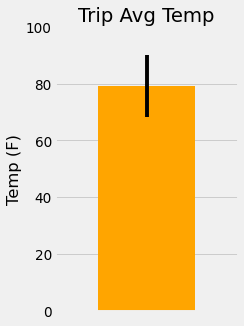

In [11]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
x_pos = [0]
y_pos = [result[1]]
error = [(result[2] - result[0])]

plt.figure(figsize=(3, 5), dpi=70)
plt.bar(x_pos,y_pos,color='orange', yerr=error)
plt.xlim(-0.75,0.75)
plt.ylim(0, 100)
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.grid(which='major', axis='x', linestyle='')

plt.savefig('Images/TripAvgTemp')
plt.show()

### Daily Rainfall Average

In [12]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
results = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation,
                        func.count(Measurement.prcp)).filter(Station.station == Measurement.station).\
                        filter((Measurement.date >= '2017-08-01') & (Measurement.date <= '2017-08-07')).\
                        group_by(Measurement.station).order_by(func.count(Measurement.prcp).desc()).all()

prcp_df = pd.DataFrame(results, columns = ['Station ID', 'Station Name', 'Latitude', 'Longitude', 
                                           'Elevation', 'Precipitation Sum']).set_index('Station ID')
prcp_df                  

,Station Name,Latitude,Longitude,Elevation,Precipitation Sum
Station ID,,,,,
USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,7
USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,6
USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,6
USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,3
USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,3


In [13]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [14]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
start_dt_obj = dt.datetime.strptime(start_date, '%Y-%m-%d')
end_dt_obj = dt.datetime.strptime(end_date, '%Y-%m-%d')

trip_dates = []
while start_dt_obj <= end_dt_obj:
    trip_dates.append(start_dt_obj)
    start_dt_obj += timedelta(days=1)

# Strip off the year and save a list of strings in the format %m-%d
trip_dates = np.ravel(trip_dates)
no_year = []
trip_dates_str = []

for trip in trip_dates:
    dateStr = trip.strftime('%m-%d')
    no_year.append(dateStr)
    trip_dates_str.append(trip.strftime('%Y-%m-%d'))
    
# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
norms = []
for year in no_year:
    norm = daily_normals(year)
    norms.append(norm)
norms

[[(67.0, 75.54, 83.0)],
 [(68.0, 75.60377358490567, 84.0)],
 [(70.0, 76.61111111111111, 85.0)],
 [(69.0, 76.71153846153847, 84.0)],
 [(69.0, 76.14814814814815, 82.0)],
 [(67.0, 76.25, 83.0)],
 [(71.0, 77.15686274509804, 83.0)]]

In [15]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_df = pd.DataFrame(norms)
df2 = pd.DataFrame(trip_df[0].to_list(), columns=['tmin', 'tavg', 'tmax'])
df2['Date'] = trip_dates_str
df2.set_index('Date', inplace=True)
df2

,tmin,tavg,tmax
Date,,,
2017-08-01,67.0,75.540000,83.0
2017-08-02,68.0,75.603774,84.0
2017-08-03,70.0,76.611111,85.0
2017-08-04,69.0,76.711538,84.0
2017-08-05,69.0,76.148148,82.0
2017-08-06,67.0,76.250000,83.0
2017-08-07,71.0,77.156863,83.0


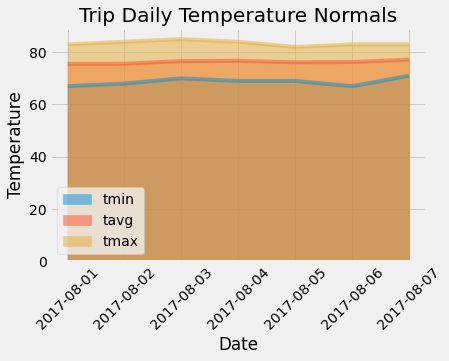

In [16]:
# Plot the daily normals as an area plot with `stacked=False`
df2.plot.area(stacked=False)
plt.xticks(rotation=45)
plt.title("Trip Daily Temperature Normals")
plt.ylabel("Temperature")
plt.legend(loc='best')

plt.savefig('Images/DailyNorms')
plt.show()

## Close Session

In [17]:
session.close()